In [152]:
import sys, os  
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
  
from IPython.display import SVG, Image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

from keras.models import Sequential  
from keras.layers import Dense, Dropout, Activation, Flatten  
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,AveragePooling2D  
from keras.losses import categorical_crossentropy  
from keras.optimizers import Adam  
from keras.regularizers import l2  
from keras.utils import np_utils  


In [153]:
!pip install -U keras-tuner
import kerastuner as kt

Requirement already up-to-date: keras-tuner in /usr/local/lib/python3.7/dist-packages (1.0.2)


In [154]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Data/fer2013.csv')
df

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


In [155]:
num_features = 64  
num_labels = 7  
batch_size = 64  
epochs = 100  
width, height = 48, 48  
img_size = 48
img_rows,img_cols=48,48

In [156]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Helper Function 01: Transform Emotion Column - Map Numerical Value to Actual Emotions.

In [157]:
# 7 Categories
# (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)

def emotions_mapping(row):
    val = row["emotion"]
    if val == 0:
        return "Angry"
    elif val == 1:
        return "Disgust"
    elif val == 2:
        return "Fear"
    elif val == 3:
        return "Happy"
    elif val == 4:
        return "Sad"
    elif val == 5:
        return "Surprise"
    else:
        return "Neutral"

df["actual_emotion"] = df.apply(emotions_mapping, axis=1)

Visualization

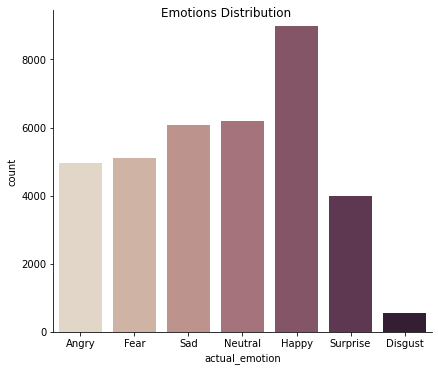

In [158]:
import seaborn as sns
ax = sns.catplot(x="actual_emotion", kind="count", palette="ch:.25", data=df, height=5, aspect=1.2)
ax.fig.suptitle("Emotions Distribution")
ax

In [159]:
train = df[df.Usage == "Training"]
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28709 entries, 0 to 28708
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   emotion         28709 non-null  int64 
 1   pixels          28709 non-null  object
 2   Usage           28709 non-null  object
 3   actual_emotion  28709 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.1+ MB


In [160]:
test  = df[df.Usage != "Training"]
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7178 entries, 28709 to 35886
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   emotion         7178 non-null   int64 
 1   pixels          7178 non-null   object
 2   Usage           7178 non-null   object
 3   actual_emotion  7178 non-null   object
dtypes: int64(1), object(3)
memory usage: 280.4+ KB


Plot Training Images - Plot Directly Using Numpy Array, not from Image.

In [161]:

train_plot = train.groupby(["actual_emotion"]).head(6)
train_plot_0 = train_plot[train_plot.emotion == 0]
train_plot_1 = train_plot[train_plot.emotion == 1]
train_plot_2 = train_plot[train_plot.emotion == 2]
train_plot_3 = train_plot[train_plot.emotion == 3]
train_plot_4 = train_plot[train_plot.emotion == 4]
train_plot_5 = train_plot[train_plot.emotion == 5]
train_plot_6 = train_plot[train_plot.emotion == 6]

In [162]:
t_list = [train_plot_0,train_plot_1, train_plot_2, train_plot_3, train_plot_4, train_plot_5, train_plot_6]

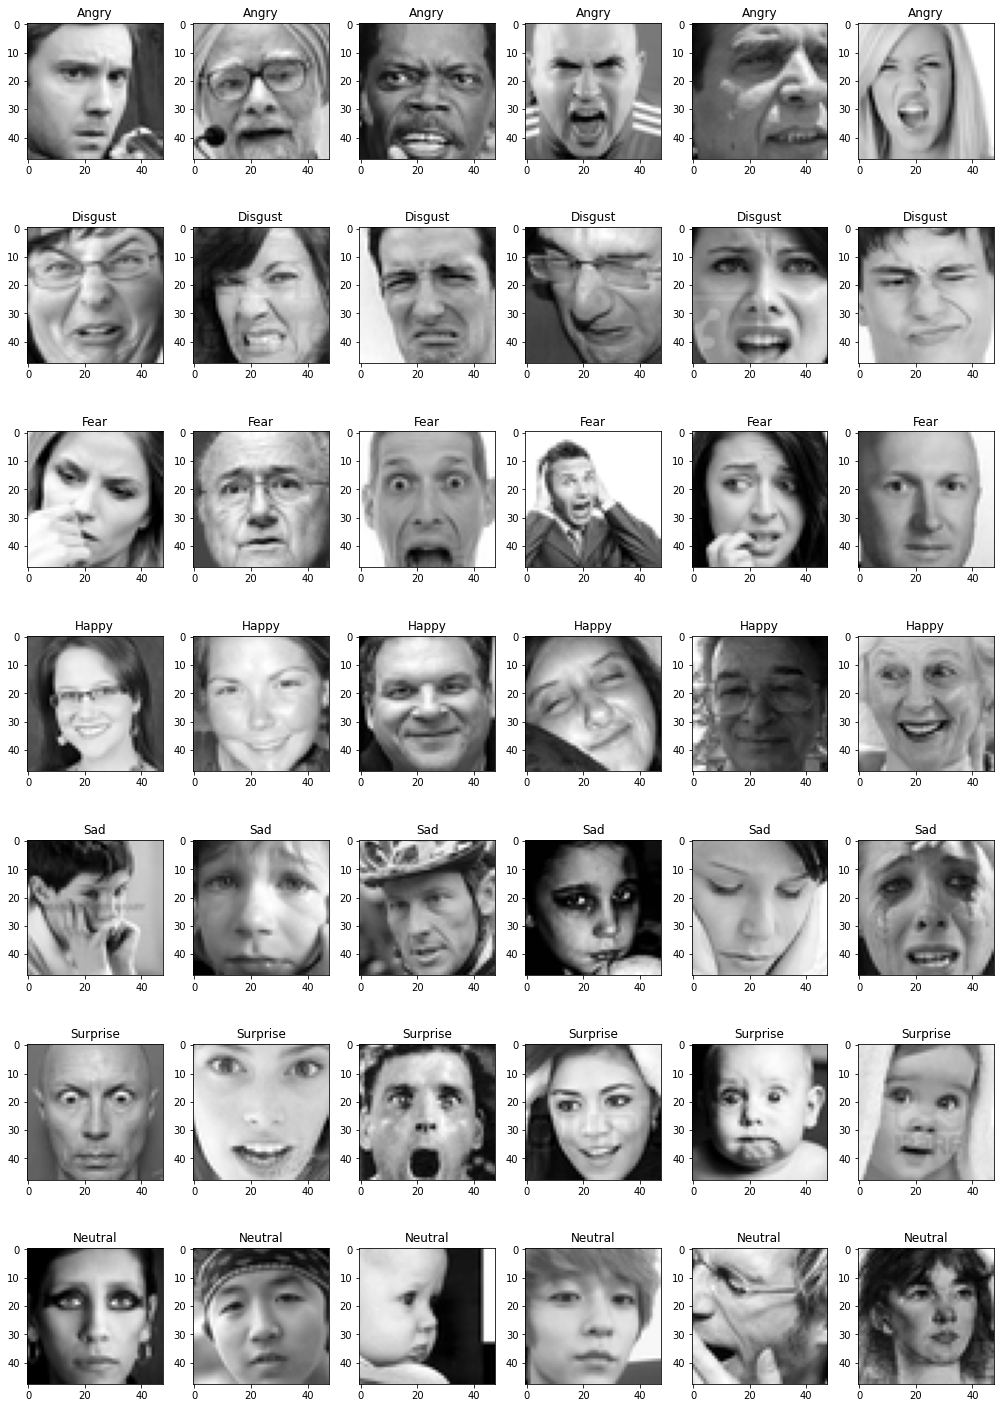

In [163]:

# Plot Images
from PIL import Image

plt.figure(0, figsize=(14, 20))
ctr = 0

for tl in t_list:
    for i, row in tl.iterrows():
        ctr += 1
        plt.subplot(7, 6, ctr, title=row["actual_emotion"])
        val = list(row["pixels"].split(' '))
        val = np.asarray(val, dtype=np.uint8)
        val = val.reshape((img_size, img_size))
        img = Image.fromarray(val)
        plt.imshow(img, cmap='gray')

plt.tight_layout()
plt.show()

In [164]:
train.actual_emotion.value_counts()

Happy       7215
Neutral     4965
Sad         4830
Fear        4097
Angry       3995
Surprise    3171
Disgust      436
Name: actual_emotion, dtype: int64

In [165]:
test.actual_emotion.value_counts()

Happy       1774
Sad         1247
Neutral     1233
Fear        1024
Angry        958
Surprise     831
Disgust      111
Name: actual_emotion, dtype: int64

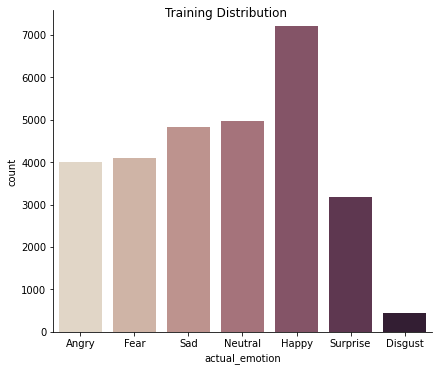

In [166]:

ax = sns.catplot(x="actual_emotion", kind="count", palette="ch:.25", data=train, height=5, aspect=1.2)
ax.fig.suptitle("Training Distribution")
ax

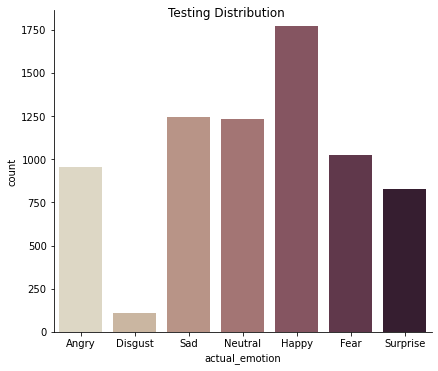

In [167]:
ax = sns.catplot(x="actual_emotion", kind="count", palette="ch:.34", data=test, height=5, aspect=1.2)
ax.fig.suptitle("Testing Distribution")
ax

We then create different lists of storing the testing and training image pixels. After this, we check if the pixel belongs to training then we append it into the training list & training labels. Similarly, for pixels belonging to the Public test, we append it to testing lists. 

In [168]:
X_train = []
y_train = []
X_test = []
y_test = []

for index, row in df.iterrows():  
    val=row['pixels'].split(" ")  
    try:  
        if 'Training' in row['Usage']:  
           X_train.append(np.array(val,'float32'))  
           y_train.append(row['emotion'])  
        elif 'PublicTest' in row['Usage']:  
           X_test.append(np.array(val,'float32'))  
           y_test.append(row['emotion'])  
    except:  
        print(f"error occured at index :{index} and row:{row}")  

In [169]:
X_train

[array([ 70.,  80.,  82., ..., 106., 109.,  82.], dtype=float32),
 array([151., 150., 147., ..., 193., 183., 184.], dtype=float32),
 array([231., 212., 156., ...,  88., 110., 152.], dtype=float32),
 array([ 24.,  32.,  36., ..., 142., 143., 142.], dtype=float32),
 array([ 4.,  0.,  0., ..., 30., 29., 30.], dtype=float32),
 array([55., 55., 55., ..., 34., 30., 57.], dtype=float32),
 array([ 20.,  17.,  19., ...,  99., 107., 118.], dtype=float32),
 array([ 77.,  78.,  79., ..., 125.,  67.,  68.], dtype=float32),
 array([85., 84., 90., ..., 58., 73., 84.], dtype=float32),
 array([255., 254., 255., ..., 254., 255., 255.], dtype=float32),
 array([ 30.,  24.,  21., ..., 172., 173., 173.], dtype=float32),
 array([39., 75., 78., ..., 84., 83., 87.], dtype=float32),
 array([219., 213., 206., ...,   0.,   0.,   0.], dtype=float32),
 array([148., 144., 130., ..., 112., 111., 111.], dtype=float32),
 array([ 4.,  2., 13., ...,  3.,  7., 12.], dtype=float32),
 array([107., 107., 109., ...,  83.,  84

In [170]:
y_train

[0,
 0,
 2,
 4,
 6,
 2,
 4,
 3,
 3,
 2,
 0,
 6,
 6,
 6,
 3,
 5,
 3,
 2,
 6,
 4,
 4,
 2,
 0,
 0,
 3,
 3,
 5,
 0,
 3,
 5,
 3,
 6,
 3,
 2,
 3,
 6,
 6,
 6,
 0,
 5,
 0,
 3,
 4,
 0,
 6,
 2,
 3,
 6,
 2,
 2,
 2,
 5,
 5,
 6,
 4,
 5,
 0,
 3,
 4,
 2,
 6,
 5,
 3,
 4,
 3,
 0,
 4,
 3,
 0,
 5,
 4,
 2,
 4,
 2,
 0,
 6,
 0,
 0,
 5,
 4,
 3,
 5,
 3,
 6,
 2,
 2,
 4,
 4,
 5,
 4,
 0,
 0,
 6,
 0,
 6,
 2,
 2,
 3,
 4,
 3,
 3,
 2,
 6,
 3,
 4,
 3,
 2,
 0,
 2,
 3,
 2,
 3,
 6,
 6,
 3,
 4,
 4,
 0,
 3,
 3,
 0,
 2,
 0,
 0,
 3,
 3,
 0,
 4,
 5,
 2,
 4,
 2,
 5,
 3,
 0,
 6,
 6,
 2,
 2,
 3,
 2,
 3,
 3,
 3,
 3,
 3,
 4,
 2,
 2,
 0,
 0,
 2,
 6,
 3,
 4,
 5,
 3,
 0,
 2,
 4,
 5,
 2,
 3,
 4,
 6,
 3,
 4,
 3,
 6,
 0,
 4,
 4,
 4,
 2,
 6,
 5,
 5,
 6,
 5,
 2,
 3,
 2,
 3,
 4,
 0,
 2,
 0,
 3,
 0,
 2,
 2,
 5,
 3,
 5,
 5,
 4,
 3,
 0,
 6,
 5,
 2,
 6,
 0,
 0,
 4,
 5,
 6,
 3,
 5,
 5,
 3,
 2,
 2,
 3,
 3,
 3,
 3,
 6,
 3,
 6,
 3,
 0,
 6,
 3,
 2,
 0,
 6,
 5,
 6,
 0,
 5,
 4,
 3,
 0,
 3,
 0,
 4,
 5,
 4,
 3,
 3,
 0,
 0,
 6,
 2,
 0,
 6,
 3,
 0,
 0,


Once we have added the pixel to the lists then we convert them into NumPy arrays and reshape X_train, X_test. After doing this we convert the training labels and testing labels into categorical ones so that the model can perform calculations with numbers.
One Hot Encoding.

In [171]:

X_train = np.array(X_train,'float32')  
y_train = np.array(y_train,'float32')  
X_test = np.array(X_test,'float32')  
y_test = np.array(y_test,'float32')  


The images are 48x48 and 1 color channel (i.e. grayscale rather than something like 3 for RGB)
Because The 2D convolution layer in Keras expects the number of channels (by default as the last dimension).


In [172]:
X_train

array([[ 70.,  80.,  82., ..., 106., 109.,  82.],
       [151., 150., 147., ..., 193., 183., 184.],
       [231., 212., 156., ...,  88., 110., 152.],
       ...,
       [ 74.,  81.,  87., ..., 188., 187., 187.],
       [222., 227., 203., ..., 136., 136., 134.],
       [195., 199., 205., ...,   6.,  15.,  38.]], dtype=float32)

In [173]:
X_train.shape

(28709, 2304)

In [174]:
y_train

array([0., 0., 2., ..., 4., 0., 4.], dtype=float32)

In [175]:
y_train.shape

(28709,)

Balancing the Data using SMOTE as there is very less data for category 'Disgust'

 SMOTE accepts only 2d array.

In [176]:
from imblearn.over_sampling import SMOTE
smote=SMOTE('minority')
X_sm, y_sm=smote.fit_sample(X_train,y_train)
print(X_sm.shape,y_sm.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(35488, 2304) (35488,)


In [177]:
X_sm = X_sm.reshape(X_sm.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

y_sm= np_utils.to_categorical(y_sm, num_classes=num_labels)
y_test = np_utils.to_categorical(y_test, num_classes=num_labels)


In [178]:
X_sm

array([[[[ 70.      ],
         [ 80.      ],
         [ 82.      ],
         ...,
         [ 52.      ],
         [ 43.      ],
         [ 41.      ]],

        [[ 65.      ],
         [ 61.      ],
         [ 58.      ],
         ...,
         [ 56.      ],
         [ 52.      ],
         [ 44.      ]],

        [[ 50.      ],
         [ 43.      ],
         [ 54.      ],
         ...,
         [ 49.      ],
         [ 56.      ],
         [ 47.      ]],

        ...,

        [[ 91.      ],
         [ 65.      ],
         [ 42.      ],
         ...,
         [ 72.      ],
         [ 56.      ],
         [ 43.      ]],

        [[ 77.      ],
         [ 82.      ],
         [ 79.      ],
         ...,
         [105.      ],
         [ 70.      ],
         [ 46.      ]],

        [[ 77.      ],
         [ 72.      ],
         [ 84.      ],
         ...,
         [106.      ],
         [109.      ],
         [ 82.      ]]],


       [[[151.      ],
         [150.      ],
         [147.

Now One Hot Encoding is done on y_train, 7 classes are there :

In [179]:
y_sm

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)


3. IMAGE AUGMENTATION for better accuracy,  and Generating Training & Validation Batches

The datagen variable will artificially expand the dataset using the following:

- rotation_range: Degree range for random rotations. Here i am using 30$^\circ$ 
- shear_range: Shear Intensity (Shear angle in counter-clockwise direction in degrees). Here i am using 0.3 as shear range.
- zoom_range: Range for random zoom..Here i am using 0.3 as zoom range.
- width_shift_range: This shifts the images by a value across its width.
- height_shift_range : This shifts the images by a value across its height.
- horizontal_flip: This flips the images horizontally.
- vertical_flip: This flips the images vertically.
- fill_mode: This is used to fill in the pixels after making changes to the orientation of the images by the above used methods. Here i am using 'nearest' as the fill mode as i am instructing it to fill the missing pixels in the image with the nearby pixels.

In [180]:
# define data preparation
datagen = ImageDataGenerator( rotation_range=30,
    shear_range=0.3,
    zoom_range=0.3,
    width_shift_range=0.4,
    height_shift_range=0.4,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')
# fit parameters from data
datagen.fit(X_sm)


Everytime you run this,you see different images as all have been vertically and horizontally flipped.

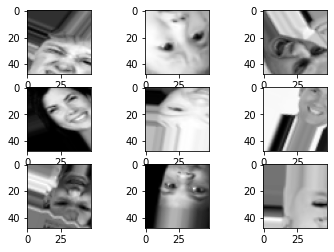

In [181]:
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(X_sm, y_sm, batch_size=batch_size):
	# create a grid of 3x3 images
	for i in range(0, 9):
		plt.subplot(330 + 1 + i)
		plt.imshow(X_batch[i].reshape(48, 48), cmap=plt.get_cmap('gray'))
	# show the plot
	plt.show()
	break

In [182]:
X_sm.shape

(35488, 48, 48, 1)

In [183]:
y_sm.shape

(35488, 7)

To design the CNN model for emotion detection with different layers, we start with the initialization of the model followed by batch normalization layer and then different convolution layers with ReLu as an activation function, max pool layers, and dropouts to do learning efficiently.

 Add more convolutional layers, to increase accuracy.

So firstly I will define the type of model that i will be using. Here i am using a Sequential model which defines that all the layers in the network will be one after the other sequentially.

In [184]:
model = Sequential()

- ### Block-1

In [185]:
model.add(Conv2D(32,(3,3),padding='same',kernel_initializer='he_normal',input_shape=(img_rows,img_cols,1)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32,(3,3),padding='same',kernel_initializer='he_normal',input_shape=(img_rows,img_cols,1)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

- ### Block-2

In [186]:
model.add(Conv2D(64,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

- ### Block-3

In [187]:
model.add(Conv2D(128,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

- ### Block-4

In [188]:
model.add(Conv2D(256,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(256,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

In [189]:
model.add(Conv2D(512,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(512,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

- ### Block-5

In [190]:
model.add(Flatten())
model.add(Dense(64,kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

- ### Block-6

In [191]:
model.add(Dense(64,kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

- ### Block-7

In [192]:
model.add(Dense(7,kernel_initializer='he_normal'))
model.add(Activation('softmax'))

Here I have used the layers of 7 types which are present in keras.layers.

The layers are:

Conv2D( filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None, **kwargs )

Activation(activation_type)

BatchNormalization()

MaxPooling2D(pool_size, strides, padding, data_format, **kwargs)

Dropout(dropout_value)

Flatten()

Dense( units, activation=None, use_bias=True, kernel_initializer="glorot_uniform", bias_initializer="zeros", kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None, **kwargs)

Block-1 layers in the order of occurrence are as follows :

Conv2D layer- This layer creates a convolutional layer for the network. Here I am creating a layer with 32 filters and a filter size of (3,3) with padding='same' to pad the image and using the kernel initializer he_normal. I have added 2 convolutional layers each followed by an activation and batch normalization layers.

Activation layer - I am using a elu activation.

BatchNormalization - Normalize the activations of the previous layer at each batch, i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1.

MaxPooling2D layer - Downsamples the input representation by taking the maximum value over the window defined by pool_size for each dimension along the features axis.Here I have used the pool_size as (2,2).

Dropout: Dropout is a technique where randomly selected neurons are ignored during training. Here I am using dropout as 0.5 which means that it will ignore half of the neurons.

Block-2 layers in the order of occurrence are as follows :
Same layers as block-1 but the convolutional layers have 64 filters.

Block-3 layers in the order of occurrence are as follows :
Same layers as block-1 but the convolutional layers have 128 filters.

Block-4 layers in the order of occurrence are as follows :
Same layers as block-1 but the convolutional layers have 256 filters.

Block-5 layers in the order of occurrence are as follows :
Flatten layer - To flatten the output of the previous layers in a flat layer or in other words in the form of a vector.

Dense layer - A densely connected layer where each neuron is connected to every other neuron. Here I am using 64 units or 64 neurons with a kernal initializer - he_normal.
These layers are followed by activation layer with elu activation , batch normalization and finally a dropout with 50% dropout.

Block-6 layers in the order of occurrence are as follows :
Same layers as blcok 5 but without flatten layer as the input for this block is already flattened.

Block-7 layers in the order of occurrence are as follows :
Dense layer - Finally in the final block of the network I am using num_classes to create a dense layer having units=number of classes with a he_normal initializer.

Activation layer - Here I am using a softmax layer which is used for multi-class classifications.

After this, we compile the model using Adam as an optimizer, loss as categorical cross-entropy, and metrics as accuracy.

In [193]:
#Compliling the model  
model.compile(loss=categorical_crossentropy,  
              optimizer=Adam(),  
              metrics=['accuracy'])  

After compiling the model we then fit the data for training and validation. Here, we are taking the batch size to be 32 with 30 epochs.

acc is the accuracy of a batch of training data and val_acc is the accuracy of a batch of testing data.

In [194]:
#Training the model  
history = model.fit(X_sm, y_sm,  
          batch_size=batch_size,  
          epochs=epochs,  
          verbose=1,  
          validation_data=(X_test, y_test),  
          shuffle=True)  
  

Epoch 1/100
555/555 [==============================] - 17s 22ms/step - loss: 2.4479 - accuracy: 0.2047 - val_loss: 4.8092 - val_accuracy: 0.0415
Epoch 2/100
555/555 [==============================] - 11s 20ms/step - loss: 1.8437 - accuracy: 0.2953 - val_loss: 2.8400 - val_accuracy: 0.0800
Epoch 3/100
555/555 [==============================] - 11s 20ms/step - loss: 1.6949 - accuracy: 0.3397 - val_loss: 3.3699 - val_accuracy: 0.1335
Epoch 4/100
555/555 [==============================] - 11s 19ms/step - loss: 1.5059 - accuracy: 0.4278 - val_loss: 2.1509 - val_accuracy: 0.3179
Epoch 5/100
555/555 [==============================] - 11s 20ms/step - loss: 1.3428 - accuracy: 0.5024 - val_loss: 1.5791 - val_accuracy: 0.4374
Epoch 6/100
555/555 [==============================] - 11s 19ms/step - loss: 1.2456 - accuracy: 0.5392 - val_loss: 1.5269 - val_accuracy: 0.4544
Epoch 7/100
555/555 [==============================] - 11s 19ms/step - loss: 1.1691 - accuracy: 0.5640 - val_loss: 1.3639 - val_ac

Once the training has been done we can evaluate the model and compute loss and accuracy.

Accuracy


In [195]:
acc = model.evaluate(X_test, y_test)
print("Loss:", acc[0], " Accuracy:", acc[1])

113/113 [==============================] - 1s 6ms/step - loss: 1.4690 - accuracy: 0.6339
Loss: 1.4689539670944214  Accuracy: 0.6338813304901123


In [196]:
pred = model.predict(X_test)
pred_y = pred.argmax(axis=-1)

In [197]:
rounded_labels=np.argmax(y_test, axis=1)
rounded_labels

array([0, 1, 4, ..., 4, 4, 4])

In [198]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(rounded_labels, pred_y)
print(cm)

[[287   5  55  15  53  15  37]
 [ 10  36   3   2   3   0   2]
 [ 61   2 255  13  76  43  46]
 [ 44   2  23 706  24  27  69]
 [ 95   6 105  23 319  22  83]
 [ 11   1  33  17   4 343   6]
 [ 91   1  50  40  83  13 329]]


In [199]:
from sklearn import metrics
print(metrics.classification_report(rounded_labels, pred_y, digits=3))

              precision    recall  f1-score   support

           0      0.479     0.615     0.538       467
           1      0.679     0.643     0.661        56
           2      0.487     0.514     0.500       496
           3      0.865     0.789     0.825       895
           4      0.568     0.489     0.525       653
           5      0.741     0.827     0.781       415
           6      0.575     0.542     0.558       607

    accuracy                          0.634      3589
   macro avg      0.628     0.631     0.627      3589
weighted avg      0.642     0.634     0.636      3589



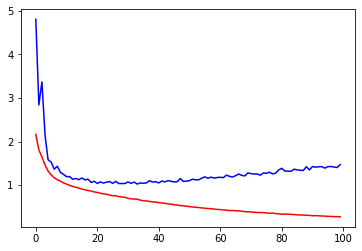

In [200]:
plt.plot(history.history['loss'], 'r')
plt.plot(history.history['val_loss'], 'b')
plt.show()

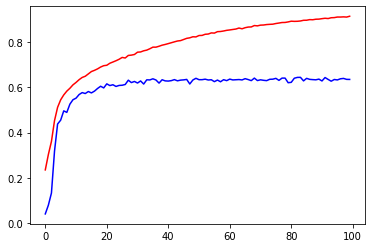

In [201]:
plt.plot(history.history['accuracy'], 'r')
plt.plot(history.history['val_accuracy'], 'b')
plt.show()